In [26]:
import sys
# sys.setdefaultencoding('utf-8')
sys.getdefaultencoding()

'utf-8'

In [1]:
import glob
import os
import os.path as osp
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# paths = glob.glob("download/webcam/*")

In [2]:
import sys
sys.path.append('/home/workspaces/mohomin/yolov7/seg/')
from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, Profile, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.segment.general import process_mask, scale_masks
from utils.segment.plots import plot_masks
from utils.torch_utils import select_device, smart_inference_mode

/home/ados/anaconda3/envs/yolov7/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torch.backends.cudnn as cudnn

In [4]:
device = select_device(0)

YOLOv5 🚀 2023-2-27 Python-3.9.16 torch-1.10.1+cu111 CUDA:0 (NVIDIA RTX A6000, 48685MiB)



In [5]:
dnn = False
half = False
weights = 'saved_models/yolov7_lens_u7_2nd.pt'
data = 'data/lens.yaml'
# weights = 'saved_models/yolov7-seg.pt'
# data = 'seg/data/coco.yaml'

model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
stride, names, pt = model.stride, model.names, model.pt

Fusing layers... 
yolov7-seg summary: 325 layers, 37853264 parameters, 0 gradients, 141.9 GFLOPs


In [22]:
video = cv2.VideoCapture('input.gif')

while True:
    ret, frame = video.read()
    if not ret:
        break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    output.write(gray_frame)

video.release()
output.release()

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [23]:
image

In [6]:
bs = 1
model.warmup(imgsz=(1 if pt else bs, 3, *imgsz))
seen, windows, dt = 0, [], (Profile(), Profile(), Profile())

NameError: name 'imgsz' is not defined

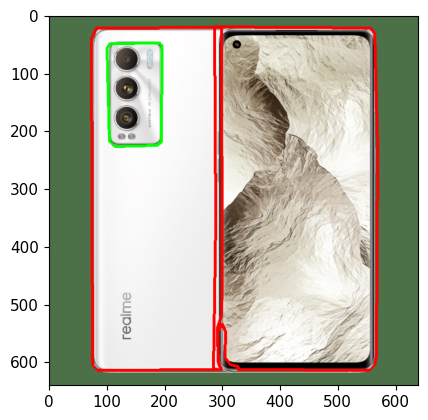

In [ ]:
%matplotlib inline
import shutil
from IPython.display import clear_output

from pathlib import Path

imgsz = (640, 640)
source = 'lens_dataset/smartphone/image/'
dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)

visualize = False
augment = False
conf_thres = 0.25
iou_thres = 0.45
classes = [0, 1] # [ 'cellphone', 'cellphone_lens', 'camera_lens']
agnostic_nms = False
max_det = 10
save_crop = False
line_thickness=3

for path, im, im0s, vid_cap, s in dataset:
# path, im, im0s, vid_cap, s = next(iter(dataset))

    with dt[0]:
        im = torch.from_numpy(im).to(device)
        im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
        im /= 255  # 0 - 255 to 0.0 - 1.0
        if len(im.shape) == 3:
            im = im[None]  # expand for batch dim

    # Inference
    with dt[1]:
        visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
        pred, out = model(im, augment=augment, visualize=visualize)
        proto = out[1]

    # NMS
    with dt[2]:
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det, nm=32)

    # Process predictions
    for i, det in enumerate(pred):  # per image
        seen += 1
        p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

        p = Path(p)  # to Path
        # save_path = str(save_dir / p.name)  # im.jpg
        # txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
        s += '%gx%g ' % im.shape[2:]  # print string
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        imc = im0.copy() if save_crop else im0  # for save_crop
        annotator = Annotator(im0, line_width=line_thickness, example=str(names))
        
        
        if len(det):
            masks = process_mask(proto[i], det[:, 6:], det[:, :4], im.shape[2:], upsample=True)  # HWC
            labels = det[:, 5].cpu().numpy().astype(np.int8)
            
            img = cv2.resize(im0, (masks.shape[2], masks.shape[1]))
            # print("origin: ")
            # plt.imshow(img)
            # plt.show()
            
            lines = []
            for i in range(masks.shape[0]):
                label = labels[i]
                cnts, _ = cv2.findContours(masks.cpu().numpy()[i][:, :, None].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
                for cnt in cnts:
                    
                    area = cv2.contourArea(cnt)
                    thres_area = 2000
                    if area < thres_area:
                        continue
                    
                    bg_mask = np.zeros(img.shape[:2], dtype=np.uint8)
                    
                    polygon = cv2.approxPolyDP(cnt, epsilon=3, closed=True)
                    cv2.polylines(bg_mask, [polygon], True, (255, 255, 255), 3)
                    cv2.fillPoly(bg_mask, [polygon], (255, 255, 255))
                    # plt.imshow(bg_mask, cmap='gray')
                    # plt.show()
                    
                    # fg = cv2.bitwise_and(img, img, mask=bg_mask)
                    # plt.imshow(fg)
                    # plt.show()
                    
                    x, y, w, h = cv2.boundingRect(bg_mask)
                    
                    if label == 0:
                        color = (255, 0, 0) # cellphone red
                    elif label == 1:
                        color = (0, 255, 0) # cellphone_lens green
                    elif label == 2:
                        color = (0, 0, 255) # camera_lens blue
                    
                    # cv2.rectangle(img, (x, y), (x+w, y+h), color, 3)
                    cv2.polylines(img, [polygon], True, color, 3)
                    
                    vertices = polygon.astype(np.float32)[:,0,:]
                    vertices[:, 0] = vertices[:, 0] / img.shape[1]
                    vertices[:, 1] = vertices[:, 1] / img.shape[0]

                    line = f"{label} {' '.join([str(v) for v in vertices.flatten()])}\n"
                    lines.append(line)
                    
            plt.imshow(img)
            plt.show()
            
            user_input = str(input())
            # if user_input == 'a':
            #     os.makedirs(osp.dirname(path).replace('unlabeled', 'label'), exist_ok=True)
            #     with open(path.replace('unlabeled', 'label').replace('.png', '.txt'), 'w') as f:
            #         f.writelines(lines)
            #     shutil.move(path, path.replace('unlabeled', 'image'))
                
            # else:
            #     os.makedirs(osp.dirname(path).replace('image', 'unlabeled'), exist_ok=True)
            #     shutil.move(path, path.replace('image', 'unlabeled'))
            clear_output()
                    # plt.imshow(fg[y:y+h, x:x+w])
                    # plt.show()


In [31]:
paths = glob.glob('lens/images/*.jpg') + glob.glob('lens/images/*.png')

with open('lens/train.txt', 'w') as f:
    for path in paths:
        f.write(path.replace('lens/','./')+'\n')

In [20]:
paths = glob.glob('copy_paste/images/*.jpg') + glob.glob('copy_paste/images/*.png')

with open('copy_paste/train.txt', 'w') as f:
    for path in paths:
        f.write(path.replace('copy_paste/','./')+'\n')

In [19]:
%matplotlib inline
import matplotlib.image as mpimg
import shutil
from IPython.display import clear_output

paths = glob.glob("download/tooth brush -icon -draw/*.png")
new_name = "tooth brush"
root_name = "objects_dataset"

os.makedirs(f"{root_name}/{new_name}/image", exist_ok=True)
os.makedirs(f"{root_name}/{new_name}/mask", exist_ok=True)

cnt = 0
for path in paths:
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    _, _, _, alpha_channel = cv2.split(im)
    _, mask = cv2.threshold(alpha_channel, 1, 255, cv2.THRESH_BINARY)
    img_rgb = cv2.cvtColor(im, cv2.COLOR_BGRA2BGR)
    
    plt.imshow(cv2.hconcat([img_rgb, cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)]))
    plt.show()
    
    user_input = str(input())
    if user_input == 'a':
        dst = f"{new_name}_{str(cnt).zfill(4)}.png"
        img_dst = osp.join(f"{root_name}/{new_name}/image", dst)
        mask_dst = osp.join(f"{root_name}/{new_name}/mask", dst)
        
        shutil.copy(path, img_dst)
        cv2.imwrite(mask_dst, mask)
        cnt += 1
    
    clear_output()

In [116]:
dst

'tooth brush_0004.png'

In [40]:
im = cv2.resize(im, (img.shape[1], img.shape[0]))

img_bgra = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
img_bgra[:, :, 3] = im[:, :]

plt.imshow(img_bgra)
plt.show()

ValueError: could not broadcast input array from shape (416,640,4) into shape (416,640)

In [30]:
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(im.shape[2:], det[:, :4], im0.shape).round()

            # Print results
            for c in det[:, 5].unique():
                n = (det[:, 5] == c).sum()  # detections per class
                s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

            # Mask plotting ----------------------------------------------------------------------------------------
            mcolors = [colors(int(cls), True) for cls in det[:, 5]]
            im_masks = plot_masks(im[i], masks, mcolors)  # image with masks shape(imh,imw,3)
            annotator.im = scale_masks(im.shape[2:], im_masks, im0.shape)  # scale to original h, w
            # Mask plotting ----------------------------------------------------------------------------------------

            # Write results
            for *xyxy, conf, cls in reversed(det[:, :6]):
                if save_txt:  # Write to file
                    xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                    line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                    with open(f'{txt_path}.txt', 'a') as f:
                        f.write(('%g ' * len(line)).rstrip() % line + '\n')

                if save_img or save_crop or view_img:  # Add bbox to image
                    c = int(cls)  # integer class
                    label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                    annotator.box_label(xyxy, label, color=colors(c, True))
                if save_crop:
                    save_one_box(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

        # Stream results
        im0 = annotator.result()
        if view_img:
            if platform.system() == 'Linux' and p not in windows:
                windows.append(p)
                cv2.namedWindow(str(p), cv2.WINDOW_NORMAL | cv2.WINDOW_KEEPRATIO)  # allow window resize (Linux)
                cv2.resizeWindow(str(p), im0.shape[1], im0.shape[0])
            cv2.imshow(str(p), im0)
            cv2.waitKey(1)  # 1 millisecond

        # Save results (image with detections)
        if save_img:
            if dataset.mode == 'image':
                cv2.imwrite(save_path, im0)
            else:  # 'video' or 'stream'
                if vid_path[i] != save_path:  # new video
                    vid_path[i] = save_path
                    if isinstance(vid_writer[i], cv2.VideoWriter):
                        vid_writer[i].release()  # release previous video writer
                    if vid_cap:  # video
                        fps = vid_cap.get(cv2.CAP_PROP_FPS)
                        w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                        h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    else:  # stream
                        fps, w, h = 30, im0.shape[1], im0.shape[0]
                    save_path = str(Path(save_path).with_suffix('.mp4'))  # force *.mp4 suffix on results videos
                    vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                vid_writer[i].write(im0)

    # Print time (inference-only)
    LOGGER.info(f"{s}{'' if len(det) else '(no detections), '}{dt[1].dt * 1E3:.1f}ms")

libpng warning: iCCP: known incorrect sRGB profile


In [31]:
pred

[tensor([], device='cuda:0', size=(0, 38))]

In [ ]:
# path = paths[0]
for path in paths:
    if osp.basename(path) == "google_done":
        continue
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()

# display(Image.open(path))

In [95]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114)):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img


In [123]:
import cv2
import numpy as np
import onnxruntime as ort

img = cv2.imread("test0000.jpg")

# height, width = img.shape[:2]
# scale = min(640.0 / width, 640.0 / height)
# img = cv2.resize(img, (int(width * scale), int(height * scale))).astype(np.float32)
img = cv2.resize(img, (640, 480))
ori_img = img.copy()
img0 = letterbox(img)
img = img0.astype(np.float16)
img /= 255.

img = img.transpose(2, 0, 1)
img = np.expand_dims(img, axis=0)

model_path = "saved_models/yolov7_lens_7_qz.onnx"
# model_path = "runs/train/yolov7_lens7/weights/best.onnx"
session = ort.InferenceSession(model_path)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

output = session.run([output_name], {input_name: img})[0]

In [124]:
output #float16

array([[          0,       417.5,         274,         474,         358,           1,     0.96289],
       [          0,      38.344,      148.62,      101.75,       230.5,           1,     0.95703],
       [          0,      216.88,      198.38,         285,         307,           1,     0.93506],
       [          0,      24.859,      114.69,      233.12,       437.5,           0,     0.91748],
       [          0,       378.5,      181.25,      453.25,      270.75,           1,     0.91553],
       [          0,      212.75,      157.38,       443.5,       512.5,           0,     0.91309],
       [          0,         401,      224.12,       628.5,         561,           0,     0.88672],
       [          0,      190.75,      402.75,      262.25,      500.25,           1,     0.85205],
       [          0,         419,      475.25,         489,         559,           1,     0.83203]], dtype=float16)

In [121]:
output #dynamic

array([[          0,      416.67,      274.42,      474.58,      360.02,           1,     0.96676],
       [          0,      36.506,       149.8,      104.48,      232.88,           1,     0.94388],
       [          0,      217.78,      196.38,      285.75,      307.15,           1,     0.92416],
       [          0,      378.91,      181.27,      451.92,      271.91,           1,     0.91944],
       [          0,      421.71,      474.58,      484.65,      557.66,           1,     0.81922],
       [          0,      190.08,      404.08,      263.09,      502.27,           1,     0.81479],
       [          0,      30.212,      115.81,      236.66,      433.04,           0,     0.72463],
       [          0,      217.78,      158.61,      446.88,      511.08,           0,     0.70425],
       [          0,      407.86,      229.11,      629.41,      561.44,           0,     0.65864]], dtype=float32)

In [112]:
output

array([[          0,      417.47,      273.89,      473.89,      358.06,           1,     0.96287],
       [          0,      38.326,      148.58,      101.78,      230.47,           1,     0.95726],
       [          0,      216.85,      198.35,      285.08,      307.02,           1,     0.93515],
       [          0,      24.865,      114.65,      233.12,       437.4,           0,     0.91756],
       [          0,      378.44,      181.25,      453.33,      270.72,           1,     0.91557],
       [          0,      212.74,      157.37,      443.57,      512.45,           0,      0.9128],
       [          0,      401.08,      224.19,       628.3,      561.12,           0,     0.88678],
       [          0,       190.8,      402.72,      262.35,      500.17,           1,     0.85238],
       [          0,      418.97,      475.23,      489.03,      558.85,           1,     0.83151]], dtype=float32)

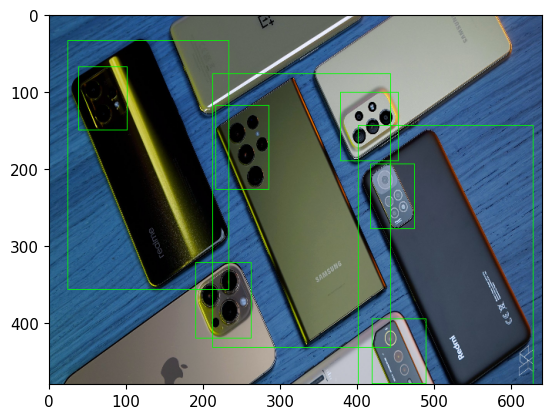

In [125]:
for _o in output:
    _, x,y,w,h,label,conf = _o
    cv2.rectangle(ori_img, (int(x), int(y)-80), (int(w), int(h)-80), (0, 255, 0), 1)

plt.imshow(ori_img)
plt.show()

In [100]:
640, 360

(640, 360)

In [101]:
() / 2

140.0